In [ ]:
%pip install orbit-ml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.9/445.9 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 12.9 MB/s eta 0:00:00
  Created wheel for orbit-ml: filename=orbit_ml-1.1.4.2-py3-none-any.whl size=475068 sha256=7c1a5df4799b6de17866d916c9f4d75c73aa79e1c7c4e1443318984d0cc05e2d
  Stored in directory: /root/.cache/pip/wheels/d6/d5/12/29fb5179003c5899b3a9281d268f9579df35bb263b985c6456
Successfully built orbit-ml


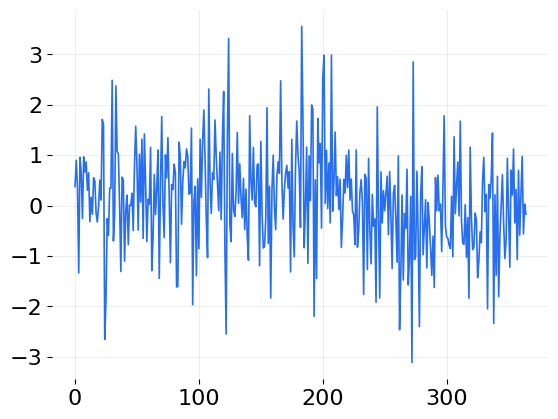

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.utils.simulation import make_trend, make_seasonality, make_regression
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())
from orbit.constants.palette import OrbitPalette

NUM_OF_REGRESSORS = 2
SERIES_LEN = 365
SEED = 20
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
seasonality = make_seasonality(SERIES_LEN, seasonality=7, method='discrete', seed=2020)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)

# combine trend and the regression
y = regression + trend + seasonality

_ = plt.plot(y, color = OrbitPalette.BLUE.value)

In [ ]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2020-01-01', periods=SERIES_LEN, freq="1W")
df['date'] = dt

# Define test size
test_size = 50

# Split data into training and testing sets
train_df = df[:-test_size]
test_df = df[-test_size:]

2024-01-25 00:32:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


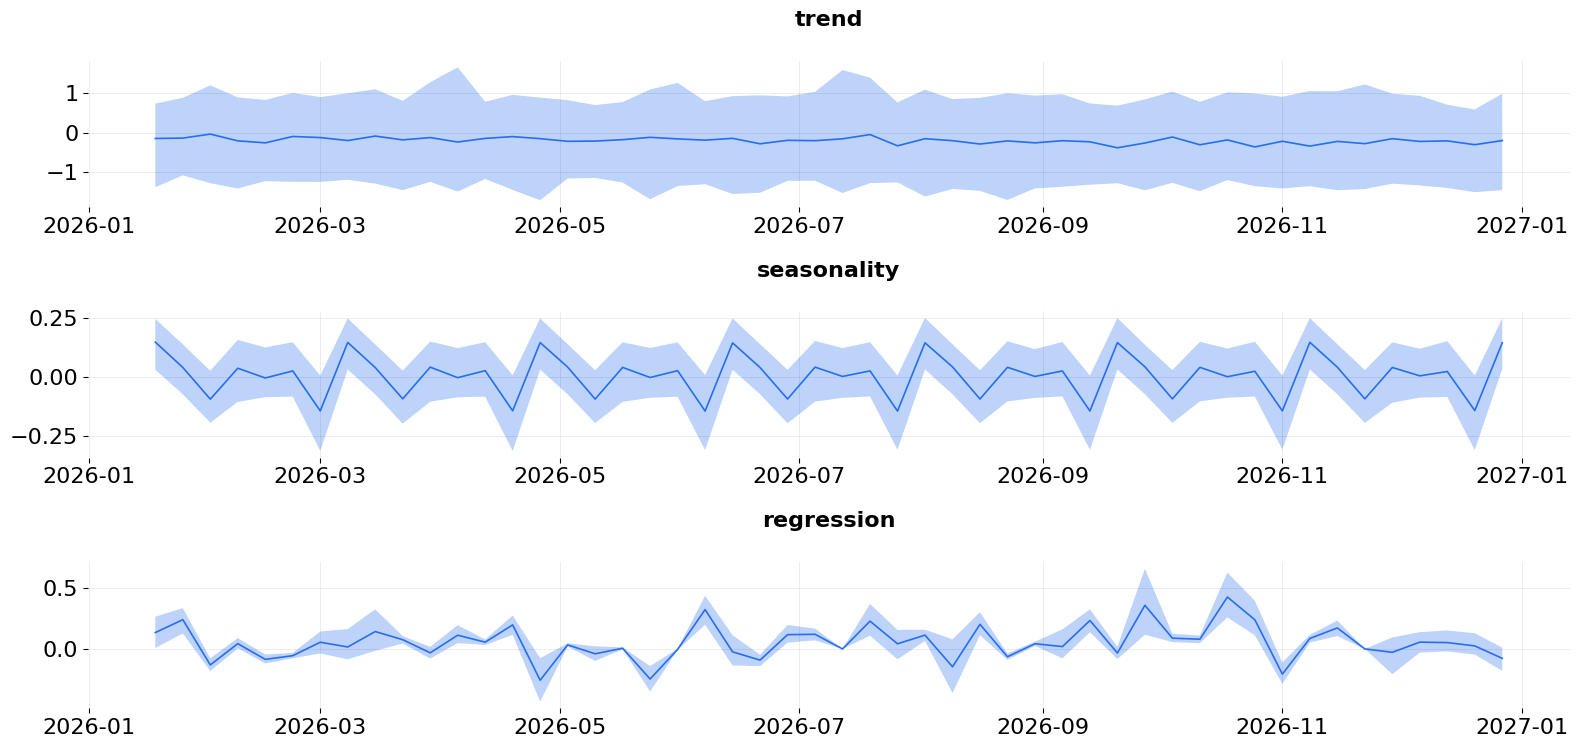

In [ ]:
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

dlt = DLT(
    response_col=response_col,
    date_col=dt_col,
    estimator='stan-mcmc',
    seed=2023,
    seasonality=7,
    regressor_col=x_cols,
    regressor_beta_prior=[0.1, 0.2],
    regressor_sigma_prior=[0.1, 1.0],
    stan_mcmc_args={'show_progress': False},
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df, decompose = True)
plot_predicted_components(predicted_df, dt_col);

In [ ]:
dlt.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,x1,Regular,-0.273512,-0.380434,-0.160515,0.00,1.00
1,x2,Regular,0.105861,-0.057037,0.262177,0.87,0.13


In [ ]:
# Evaluate model
actual_values = df[response_col][-test_size:].values

regress_predicted_values = predicted_df['prediction'].values

mae = mean_absolute_error(actual_values, regress_predicted_values)
mse = mean_squared_error(actual_values, regress_predicted_values)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 0.7173303986387861
Mean Squared Error (MSE): 0.7814852152375025
Root Mean Squared Error (RMSE): 0.8840165243011595


**Backtesting**

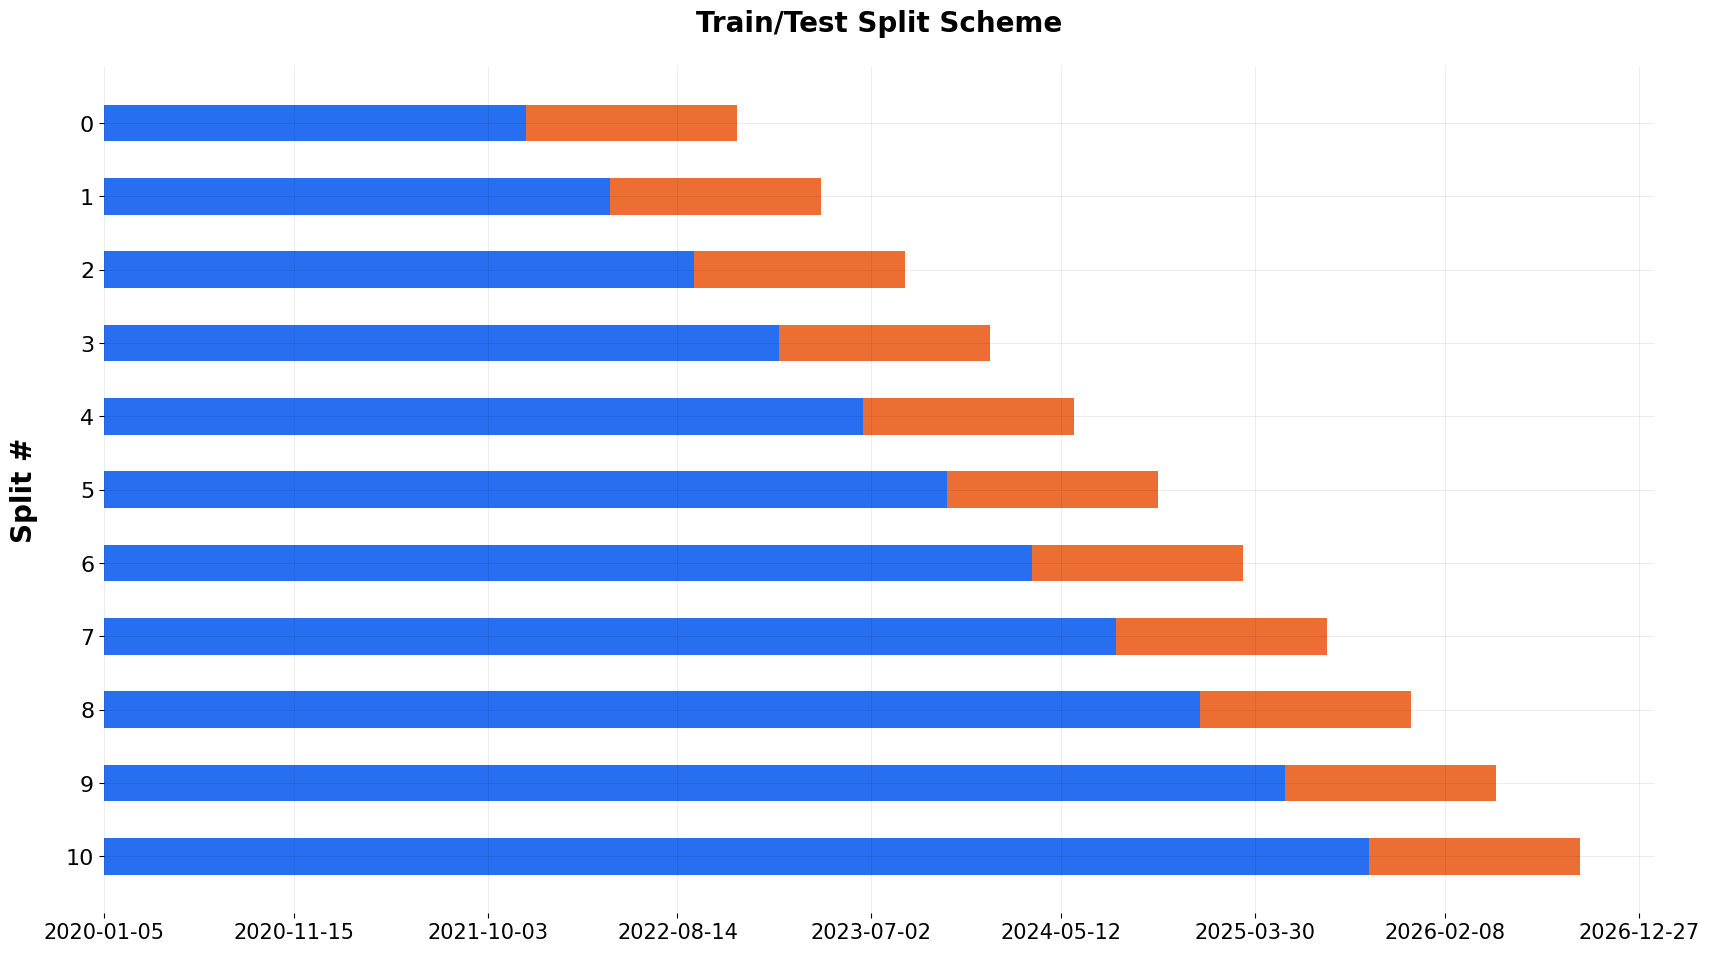

In [ ]:
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.diagnostics.plot import plot_bt_predictions
from orbit.diagnostics.metrics import smape, wmape
from orbit.utils.dataset import load_iclaims

# configs
min_train_len = 100
forecast_len = 50
incremental_len = 20
window_type = 'expanding'

ex_splitter = TimeSeriesSplitter(df=df,
                                 min_train_len=min_train_len,
                                 incremental_len=incremental_len,
                                 forecast_len=forecast_len,
                                 window_type=window_type,
                                 date_col=dt_col)

_ = ex_splitter.plot()

In [ ]:
# instantiate a model
dlt = DLT(
    response_col=response_col,
    date_col=dt_col,
    estimator='stan-mcmc',
    seed=2023,
    seasonality=7,
    regressor_col=x_cols,
    regressor_beta_prior=[0.1, 0.2],
    regressor_sigma_prior=[0.1, 1.0],
    stan_mcmc_args={'show_progress': False},
)

# instantiate a backtester
bt = BackTester(
    model=dlt,
    df=df,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

bt.fit_predict()

predicted_df = bt.get_predicted_df()
predicted_df.head()

2024-01-25 00:38:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-01-25 00:38:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-01-25 00:38:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-01-25 00:39:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


,date,actual,prediction_5,prediction,prediction_95,training_data,split_key
0,2020-01-05,0.377151,-0.385693,0.460290,1.209727,True,0
1,2020-01-12,0.896826,-0.497820,0.444708,1.231423,True,0
2,2020-01-19,0.360376,-0.961313,0.078870,0.950148,True,0
3,2020-01-26,-1.337198,-0.436841,0.288891,1.124085,True,0
4,2020-02-02,0.960094,-0.437414,0.401367,1.112923,True,0


/usr/local/lib/python3.10/dist-packages/orbit/diagnostics/plot.py:428: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


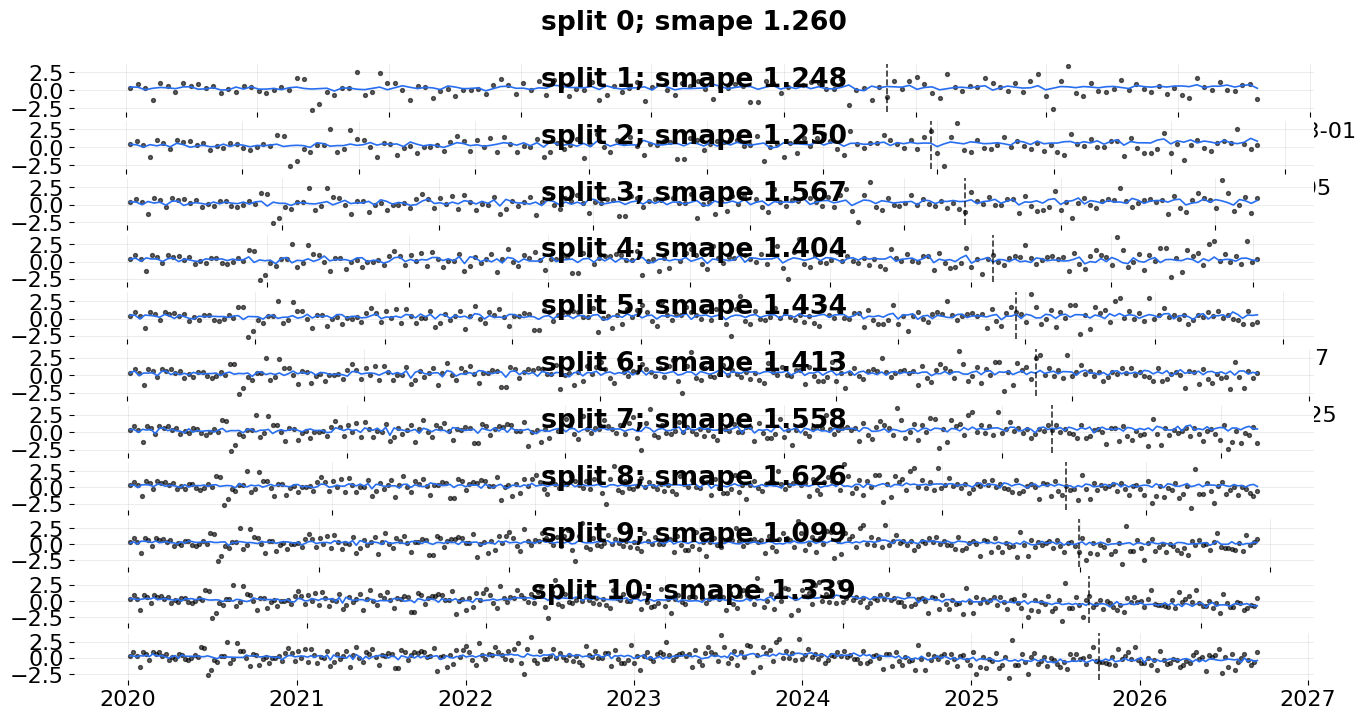

In [ ]:
plot_bt_predictions(predicted_df, metrics=smape, ncol=1, include_vline=True);

In [ ]:
bt.score(include_training_metrics=True)

,metric_name,metric_values,is_training_metric
0,smape,1.381659,False
1,wmape,1.028326,False
2,mape,2.071294,False
3,mse,1.206760,False
4,mae,0.860448,False
5,rmsse,0.698845,False
6,smape,1.316068,True
7,wmape,0.919337,True
8,mape,13.799442,True
9,mse,0.962266,True


**Hyperparameter** **Tunning**

In [ ]:
from orbit.utils.params_tuning import grid_search_orbit
# defining the search space for level smoothing paramter and seasonality smooth paramter
param_grid = {
    'level_sm_input': [0.3, 0.5, 0.8],
    'seasonality_sm_input': [0.3, 0.5, 0.8],
}

# configs
min_train_len = 80 # minimal length of window length
forecast_len = 50 # length forecast window
incremental_len = 30 # step length for moving forward
window_type = 'expanding'

best_params, tuned_df = grid_search_orbit(
    param_grid,
    model=dlt,
    df=df,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type = window_type,
    metrics=None,
    criteria="min",
    verbose=False,
)

  0%|          | 0/9 [00:00<?, ?it/s]

2024-01-25 00:51:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-01-25 00:51:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-01-25 00:51:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-01-25 00:51:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


In [ ]:
best_params

[{'level_sm_input': 0.3, 'seasonality_sm_input': 0.3}]

**Test Performance of DLT model with best hyperparameters**

In [ ]:
# instantiate a model
dlt = DLT(
    date_col=dt_col,
    response_col=response_col,
    seasonality=7,
    estimator='stan-mcmc',
    regressor_beta_prior=[0.1, 0.2],
    regressor_sigma_prior=[0.1, 1.0],
    level_sm_input = 0.3,
    seasonality_sm_input = 0.3,
    verbose=False,
)

dlt.fit(df)
test_df = dlt.make_future_df(periods=50)
predicted_df = dlt.predict(test_df)

actual_values = df[response_col][-50:].values

predicted_values = predicted_df['prediction'].values

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                                                                                                
Mean Absolute Error (MAE): 0.8634164807816687
Mean Squared Error (MSE): 1.1625651639999801
Root Mean Squared Error (RMSE): 1.0782231513003142
